# House Prices - Advanced Regression Techniques

## Deva Kulkarni, Jared Dec, Marc Semonick, Trevor Johnson

## October 2021

<br>

Competition Link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Goal: Predict sales price for each house (`SalePrice`). RMSE on log(pred) - log(actual) will be the evaluation metric. 

Inference Problem:  Given known variables about a house, accurately predict its sale price.

Deliverable: Final submission dataset should contain only the two fields `ID` and `SalePrice`. 

# Setups

Import modules

In [288]:
import os 

# data manipulation/viz
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# modeling setups
from patsy import dmatrices
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

# linear modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
from statsmodels.formula.api import glm 

# tree modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

Load in the data

In [289]:
# optional directory set-up
working_dir = !pwd
train = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "train.csv"))
test = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "test.csv"))
sample = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "sample_submission.csv"))

In [290]:
print("train shape: {}".format(train.shape))
print("test shape: {}".format(test.shape))

train shape: (1460, 81)
test shape: (1459, 80)


Base functions for standard data cleanining to use in all models

In [291]:
def na_clean(df):
    
    # some vars are just too missing so I remove the field
    df = df.drop(columns = ["PoolQC", "MiscFeature"])

    # replace some numeric vars w/ median
    median_replace_vars = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
    for var in median_replace_vars:
        df[var].fillna(df[var].median(), inplace = True)
    
    # replace some num vars w/ 0
    zero_replace_vars = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']
    for var in zero_replace_vars:
        df[var].fillna(0, inplace = True)
    
    # replace some cat vars w/ most freq value 
    df['MasVnrType'].fillna('None', inplace = True)
    df['Electrical'].fillna('SBrkr', inplace = True)
    df['MSZoning'].fillna('RL', inplace = True)
    df['SaleType'].fillna('WD', inplace = True)
    df['Utilities'].fillna('AllPub', inplace = True)
    df['KitchenQual'].fillna('TA', inplace = True)
    df['Functional'].fillna('Typ', inplace = True)

    # other cat vars just put missing if there isn't a glaring most popular category
    replace_missing_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Exterior1st', 
        'Exterior2nd', 'FireplaceQu']
    for var in replace_missing_vars:
        df[var].fillna("Missing", inplace = True)

    return df



# Function for some standard feature engineering to use in all models
def standard_feature_eng(df, test_data = False):
    '''Input either the training or test data. 
    2nd arg set to True if it's the testing data. That way we ignore the final log transformation on sale price'''

    # num features to just binarize b/c few houses have the feature
    df["SwimmingPool"] = df['PoolArea'].map(lambda x: 0 if x==0 else 1)
    df["3SsnPorch"] = df['3SsnPorch'].map(lambda x: 0 if x==0 else 1)
    df["ScreenPorch"] = df['ScreenPorch'].map(lambda x: 0 if x==0 else 1)

    # re-factoring vars:
    # group the irregularities into 2 factor levels
    df['LotShape'] = df['LotShape'].map({'Reg': 'Reg', 'IR1': 'Reg', 'IR2': 'Irreg', 'IR3': 'Irreg'})

    # simplifying MSSubClass because we have the year built in another feature
    df['MSSubClass'] = df['MSSubClass'].map(lambda x: 
        "1_story"   if (x in (20, 30, 40, 120)) else(
        "1.5_story" if (x in (45, 50, 150)) else(
        "2_story"   if (x in (60, 70, 75, 160, 180, 190)) else(
        "split"     if (x in (80, 85)) else(
        "duplex"    if (x ==90) else(
        "other"))))))
    df['MSSubClass'] = df['MSSubClass'].astype("object")

    # simplifying more vars
    # electrical:
    df['Electrical'] = df['Electrical'].map(lambda x: "SBrkr" if x == "SBrkr" else "Fuse")
    # exterior:
    df['Exterior'] = df['Exterior1st'].map(lambda x: 
        # group exterior into simplified var based on average prices
        "Expensive" if (x in ("VinylSd", "CemntBd", "Stone", "ImStucc")) else(
        "Cheap" if (x in ("BrkComm", "AsphShn", "CBlock", "AsbShng")) else(
        "Moderate")))
    df = df.drop(columns=['Exterior1st', 'Exterior2nd'])
    # garage
    df['GarageQual'] = df['GarageQual'].map(lambda x: 
        # group exterior into simplified var based on average prices
        "Good" if (x in ("Ex", "Gd")) else(
        "Medium" if (x in ("TA")) else(
        "Bad")))
    df['Heating'] = df['Heating'].map(lambda x: "Gas" if x in ("GasA", "GasW") else "Other")

    # deciding to drop a few features for various reasons
    vars_to_drop = [
        # not much variation:
        "LowQualFinSF", 
        "LandSlope", 
        "MiscVal", 
        "RoofMatl",
        "Condition2",
        #"KitchenAbvGr" # hardly any variation. But, Deva included in lm's so including it now.
        "PoolArea", # binarized above
        "Utilities", # only 1 obs in training data different from regular
        "HouseStyle" # already explained in other vars
        ]
    df.drop(columns=vars_to_drop, inplace=True) 

    # adding a remodeled feature
    df['Remodeled'] = (df.YearRemodAdd-df.YearBuilt) == 0

    # total inside area will be a sum of 1st and 2nd floor sq ft
    df['Total_Inside_Area'] = df['1stFlrSF'] + df['2ndFlrSF']
    df.drop(columns = ['1stFlrSF', '2ndFlrSF', 'GrLivArea'], inplace = True)

    # simplify the bathrooms variable
    df['Bathrooms'] = df.BsmtFullBath + 0.5*df.BsmtHalfBath + df.FullBath + 0.5*df.HalfBath
    df.drop(columns = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace = True)

    # get log of sale price which will be our actual response variable
    if test_data:
        pass 
    else:
        df['LogSalePrice'] = np.log(df.SalePrice)

    return df

# Modeling

## OLS

Function to prep data for a very baseline linear model

In [292]:
def lm_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    lm_vars = ['LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearRemodAdd', 
              'BsmtCond', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 
              'MoSold', 'Remodeled', 'Total_Inside_Area', 'Bathrooms']

    df = pd.get_dummies(df[lm_vars], 
        columns = ['Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'BsmtCond','KitchenQual'], 
        drop_first=True)
    
    return df

Train OLS model

In [293]:
# data setups
X_train = lm_df_clean(train)
X_test = lm_df_clean(test, test_data=True)
Y_train = train.SalePrice
Y_test = sample.SalePrice

# fit to train data
lr_1 = LinearRegression(fit_intercept=True).fit(X_train, Y_train)

Evaluate performance. Baseline OLS model is very overfit

In [294]:
print("Fit on training data: {:.3f}".format(lr_1.score(X_train,Y_train)))
print("Fit on testing data: {:.3f}".format(lr_1.score(X_test ,Y_test)))

yhat_train = lr_1.predict(X_train)
yhat_test = lr_1.predict(X_test)

# rmse
rmse_train = (np.mean((np.log(yhat_train) - np.log(Y_train))**2))**.5
rmse_test = (np.mean((np.log(yhat_test) - np.log(Y_test))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))


Fit on training data: 0.850
Fit on testing data: -17.593
Log RMSE on training data: 0.146
Log RMSE on testing data: 0.378


## OLS with 1 variable

An OLS with 1 variable, overall quality, outperforms the more complex OLS model with many features. This uses the variable with highest coefficient from initial correlation matrix.

In [295]:
# data setup function
def lm_overall_quality_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)
    df = df.loc[:, ['OverallQual']]
    
    return df

In [296]:
# data setups
X_train = lm_overall_quality_df_clean(train)
X_test = lm_overall_quality_df_clean(test, test_data=True)
Y_train = train.SalePrice
Y_test = sample.SalePrice

# fit to train data
lr_overall_quality = LinearRegression(fit_intercept=True).fit(X_train, Y_train)

In [297]:
# Evaluate performance
print("Fit on training data: {:.3f}".format(lr_overall_quality.score(X_train,Y_train)))
print("Fit on testing data: {:.3f}".format(lr_overall_quality.score(X_test ,Y_test)))

yhat_train = lr_overall_quality.predict(X_train)
yhat_test = lr_overall_quality.predict(X_test)

# set negative values to 0.1
yhat_train = np.array([0.1 if i < 0 else i for i in yhat_train])
yhat_test = [0.1 if i < 0 else i for i in yhat_test]

# rmse
rmse_train = (np.mean((np.log(yhat_train) - np.log(Y_train))**2))**.5
rmse_test = (np.mean((np.log(yhat_test) - np.log(Y_test))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))


Fit on training data: 0.626
Fit on testing data: -14.882
Log RMSE on training data: 0.811
Log RMSE on testing data: 1.354


## Lasso model v1

In [298]:
# data setup function
def lasso_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    #df = standard_feature_eng(df, test_data = test_data)

    # log transformations
    df["GrLivArea"] = np.log(df["GrLivArea"])

    # select only vars needed
    if test_data:
        df = df[["GrLivArea","OverallQual"]] 
    else:
        df["SalePrice"] = np.log(df["SalePrice"])
        df = df[["GrLivArea","OverallQual", "SalePrice"]]
    
    return df

In [299]:
# data setups
X_train = lasso_df_clean(train)
X_test = lasso_df_clean(test, test_data=True)
Y_train = X_train.SalePrice
Y_test = np.log(sample.SalePrice)

# fit to train data
lasso_fit_v1 = Lasso(alpha=.01).fit(X_train[["GrLivArea","OverallQual"]], Y_train)

In [300]:
# Evaluate performance
yhat_train = lasso_fit_v1.predict(X_train[["GrLivArea","OverallQual"]])
yhat_test = lasso_fit_v1.predict(X_test[["GrLivArea","OverallQual"]])

# rmse
rmse_train = (np.mean((yhat_train - np.log(train.SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("RMSE on training data: {:.3f}".format(rmse_train))
print("RMSE on testing data: {:.3f}".format(rmse_test))

RMSE on training data: 0.202
RMSE on testing data: 0.332


## Lasso model v2

I think i used the wrong lasso model above. Using this one instead

In [301]:
# first build one hot encoder based on the training data
train_lasso = standard_feature_eng(na_clean(train))
enc_lasso = OneHotEncoder(handle_unknown = 'ignore')
enc_lasso.fit(train_lasso.select_dtypes(include=["object"]))
one_hot_columns = pd.get_dummies(train_lasso.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

# data setup function
def lasso_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_lasso.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)

    # log transformations
    #df["GrLivArea"] = np.log(df["GrLivArea"])
    
    # select only vars needed
    if test_data:
        df = df.drop(columns=["Id"])
    else:
        df = df.drop(columns=["Id"])
        df['SalePrice'] = np.log(df['SalePrice'])
        #df = df[["GrLivArea","OverallQual", "SalePrice"]]
    
    return df

In [302]:
# data setups
X_train = lasso_df_clean(train)
X_test = lasso_df_clean(test, test_data=True)
Y_train = X_train.SalePrice
Y_test = np.log(sample.SalePrice)

# fit to train data
lasso_fit = Lasso(alpha=.01).fit(X_train.drop(columns=['LogSalePrice', 'SalePrice']), Y_train)

In [303]:
# Evaluate performance
yhat_train = lasso_fit.predict(X_train.drop(columns=['LogSalePrice', 'SalePrice']))
yhat_test = lasso_fit.predict(X_test)

# rmse
rmse_train = (np.mean((yhat_train - np.log(train.SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("RMSE on training data: {:.3f}".format(rmse_train))
print("RMSE on testing data: {:.3f}".format(rmse_test))

RMSE on training data: 0.155
RMSE on testing data: 0.357


## Random forest with cross validation

In [304]:
# first build one hot encoder based on the training data
train_rf = standard_feature_eng(na_clean(train))
enc_rf = OneHotEncoder(handle_unknown = 'ignore')
enc_rf.fit(train_rf.select_dtypes(include=["object"]))
one_hot_columns = pd.get_dummies(train_rf.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

In [305]:
# Random forest data clean function
def rf_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_rf.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # DO FEATURE ENGINEERING HERE
    # drop irrelevant columns
    df = df.drop(columns=["Id"])
    
    return df

Running this cross validation grid search took almost 30 minutes on my computer. I commented the results at the bottom so we don't have to keep re-running.

In [306]:
# preprocess the data
df_rf = rf_df_clean(train)

# create the train and test splits
dev_train, dev_test = train_test_split(df_rf, test_size=0.1, random_state=1)

# specify model
rf = RandomForestRegressor(bootstrap=True, max_features='auto')

# run grid search on range of values
grid = {
    "n_estimators": np.arange(100, 1001, 100),
    'max_depth': np.arange(10, 101, 5),
    'min_samples_split': [2, 5, 7],
}

# put our parameters into GridSearch
gscv = GridSearchCV(
    estimator = rf, 
    param_grid = grid, 
    n_jobs = -1, 
    cv = 3)

# run the search:
# this took 26 min to run. 
# re-run if you want
#results = gscv.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice']), dev_train.LogSalePrice)

# check out the best parameters
# print(results.best_params_)
# {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 900}

In [307]:
# finally, run model on best parameters
rf_reg = RandomForestRegressor(
    n_estimators = 900,
    max_depth = 25,
    max_features = 'auto',
    min_samples_split = 2,  
    bootstrap = True, 
    )

# fit the model
rf_reg.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice']), dev_train.LogSalePrice)

# evaluate it's performance on the unforseen testing set
yhat = rf_reg.predict(dev_test.drop(columns = ["SalePrice", 'LogSalePrice']))
# convert log scale back to normal scale
#yhat = np.exp(yhat)
resids = yhat - np.log(dev_test.SalePrice)

# evaluate rmse  on the testing data
print("RMSE: " + str(round(np.mean(resids**2)**.5,4)))
# MAE: 0.0999
# RMSE: 0.154

RMSE: 0.1442


In [308]:
# score on train
rf_train_score = rf_reg.score(dev_train.drop(columns = ["SalePrice", 'LogSalePrice']), dev_train.SalePrice)
print("Score on train: {:.3f}".format(rf_train_score))

# score on dev
rf_dev_score = rf_reg.score(dev_test.drop(columns = ["SalePrice", 'LogSalePrice']), dev_test.SalePrice)
print("Score on test: {:.3f}".format(rf_dev_score))

Score on train: -5.307
Score on test: -4.323


In [309]:
# evaluate performance on test set
preds = rf_reg.predict(rf_df_clean(test, test_data=True))
redids = preds - np.log(sample.SalePrice)
print("Log RMSE: " + str(round(np.mean(resids**2)**.5,4)))

Log RMSE: 0.1442


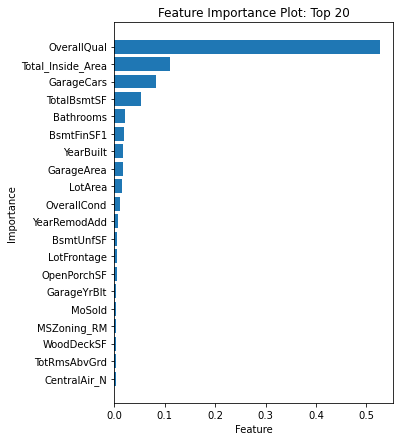

In [310]:
# variable importance plot
var_imp = pd.DataFrame({
    'feature': dev_train.drop(columns = ["SalePrice", 'LogSalePrice']).columns,
    'importance': rf_reg.feature_importances_
})
var_imp.sort_values("importance", ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(5, 7))
topn = 20
ax.barh(var_imp.head(topn).feature, var_imp.head(topn).importance)
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")
ax.set_title("Feature Importance Plot: Top {}".format(topn))
ax.invert_yaxis()
print("")

## Gradient boosting regression

In [311]:
# first build one hot encoder based on the training data
train_xgb = standard_feature_eng(na_clean(train))
enc_xgb = OneHotEncoder(handle_unknown = 'ignore')
enc_xgb.fit(train_xgb.select_dtypes(include=["object"]))
one_hot_columns_xgb = pd.get_dummies(train_xgb.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

In [312]:
# xgboost data clean function
def xgb_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_xgb.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns_xgb
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # DO MORE FEATURE ENGINEERING HERE LATER
    df = df.drop(columns = ['Id'])
    
    return df

In [313]:
# preprocess the data
df_xgb = xgb_df_clean(train)

# get X feature names
xgb_cols = np.array(df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']).columns)

# create the train and test splits
dev_train_X, dev_test_X, dev_train_y, dev_test_y = train_test_split(
    df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']), 
    np.log(df_xgb['SalePrice']), 
    test_size=0.3, random_state=1)

# convert data to DMatrix format
dmat_train = xgb.DMatrix(dev_train_X, dev_train_y, feature_names=xgb_cols)
dmat_test = xgb.DMatrix(dev_test_X, dev_test_y, feature_names=xgb_cols)

Cross validate to find optimal hyperparameters

In [314]:
# do this later

Choosing a set of example values for now

In [315]:
booster = xgb.train({

    "booster": "gbtree", 
    "max_depth": 30, 
    "eta": .4, 
    "gamma": .01, 
    "subsample": 0.6,
    "lambda": .7, 
    "alpha": 0, 
    "max_bin": 256, 
    "colsample_bytree": .7, # proportion of features
    "eval_metric": "rmse", 
    "objective": "reg:squarederror"
    },

    dmat_train,
    evals=[(dmat_train, "train"), (dmat_test, "test")] 
)

[0]	train-rmse:6.93825	test-rmse:6.91274
[1]	train-rmse:4.17557	test-rmse:4.15475
[2]	train-rmse:2.51648	test-rmse:2.49702
[3]	train-rmse:1.52524	test-rmse:1.51262
[4]	train-rmse:0.92922	test-rmse:0.92159
[5]	train-rmse:0.57431	test-rmse:0.57302
[6]	train-rmse:0.36348	test-rmse:0.37158
[7]	train-rmse:0.23908	test-rmse:0.26214
[8]	train-rmse:0.16364	test-rmse:0.20740
[9]	train-rmse:0.12008	test-rmse:0.18025


In [316]:
# evaluate final performance on test
df_xgb_test = xgb.DMatrix(xgb_df_clean(test, test_data=True))
preds = booster.predict(df_xgb_test)
redids = preds - np.log(sample.SalePrice)
print("Log RMSE: " + str(round(np.mean(resids**2)**.5,4)))

Log RMSE: 0.1442


# Final Ensemble model

This doesn't work yet, but this is how I have in mind to make the final predictions. Make sure each of these models are pretrained from above:
- OLS (lr_1)
- OLS Simple (lr_overall_quality)
- GLM (still want this??)
- Lasso (update)
- Random forest (rf_reg)
- Extreme gradient boosting machine (update)


Then we can pass in brand new incoming data to make predictions with this function

In [317]:
# Load in brand new data to make sure it all works
working_dir = !pwd
train = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "train.csv"))
test = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "test.csv"))
sample = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "sample_submission.csv"))

In [318]:
def housing_ensemble_model(df):
    '''This is the final model that takes in raw data, and makes predictions'''

    # OLS
    yhat_ols1 = lr_1.predict(lm_df_clean(df, test_data=True))

    # OLS Simple
    yhat_ols_simple = lr_overall_quality.predict(lm_overall_quality_df_clean(df, test_data=True))

    # GLM

    # Lasso
    lasso_data = lasso_df_clean(df, test_data=True)
    yhat_lasso = np.exp(lasso_fit.predict(lasso_data))

    # Random forest
    yhat_rf = np.exp(rf_reg.predict(rf_df_clean(df, test_data=True)))

    # XGB
    xgb_data = xgb.DMatrix(xgb_df_clean(df, test_data=True)) #, feature_names=xgb_cols)
    yhat_xgb = np.exp(booster.predict(xgb_data))

    # make ensemble prediction
    # Do more work to come up w/ weights. This is just a sample
    yhat_final = yhat_ols1*(1/5) + yhat_ols_simple * (1/5) + yhat_lasso * (1/5) + yhat_rf * (1/5) + yhat_xgb * (1/5)

    return yhat_final


In [319]:
# final ensemble model RMSE
yhat_train = housing_ensemble_model(train.drop(columns = ["SalePrice"]))
yhat_test = housing_ensemble_model(test)

rmse_train = np.mean((train.SalePrice - yhat_train)**2)**.5
rmse_test = np.mean((sample.SalePrice - yhat_test)**2)**.5

# evaluate rmse  on the testing data
print("RMSE Train: {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))

# log results
rmse_train_log = np.mean((np.log(train.SalePrice) - np.log(yhat_train))**2)**.5
rmse_test_log = np.mean((np.log(sample.SalePrice) - np.log(yhat_test))**2)**.5
# evaluate rmse  on the testing data
print("\nLog RMSE Train: {}".format(rmse_train_log))
print("Log RMSE Test: {}".format(rmse_test_log))


RMSE Train: 28710.142754405526
RMSE Test: 64689.67331186708

Log RMSE Train: 0.1263249376391182
Log RMSE Test: 0.3608842664804068


# Scratch work below for sample submissions

In [320]:
lasso_data = lasso_df_clean(test, test_data=True)
yhat_lasso = lasso_fit.predict(lasso_data)

In [323]:
sample_submission = pd.DataFrame({
    "Id": test.Id,
    "SalePrice": np.exp(yhat_lasso)
})
sample_submission.to_csv("~/Desktop/sample_submission_lasso.csv", index=False)